In [1]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [2]:
ticker = "AAPL"
name = "Apple"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

2

In [ ]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

# use celery / async
# market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

In [3]:
import pandas as pd
from market import services as market_services
days = 360
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)
historical_data_list = queryset.values(
    'time', 'open_price', 'close_price', 'high_price', 'low_price',
    'raw_timestamp', 'number_of_trades', 'volume', 'volume_weighted_average'
)

historical_data = pd.DataFrame.from_records(historical_data_list)
historical_data['time'] = pd.to_datetime(historical_data['time'])
historical_data.set_index('time', inplace=True)
historical_data = historical_data[['close_price']]
print(historical_data.head())

                          close_price
time                                 
2024-02-20 23:55:00+00:00    181.7000
2024-02-21 23:55:00+00:00    182.4700
2024-02-22 23:55:00+00:00    184.2400
2024-02-23 23:55:00+00:00    182.3300
2024-02-24 00:55:00+00:00    182.2800


In [4]:
print(historical_data.columns)

Index(['close_price'], dtype='object')


In [5]:
print(historical_data.head())
print(historical_data.dtypes)

                          close_price
time                                 
2024-02-20 23:55:00+00:00    181.7000
2024-02-21 23:55:00+00:00    182.4700
2024-02-22 23:55:00+00:00    184.2400
2024-02-23 23:55:00+00:00    182.3300
2024-02-24 00:55:00+00:00    182.2800
close_price    object
dtype: object


In [6]:
from merlion.models.forecast.deep_ar import DeepARForecaster, DeepARConfig
from merlion.utils import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from merlion.models.forecast.deep_ar import DeepARForecaster
print(DeepARForecaster.__init__.__annotations__)


{'config': <class 'merlion.models.forecast.deep_ar.DeepARConfig'>}


In [8]:
print(historical_data.dtypes)

close_price    object
dtype: object


In [9]:
from merlion.models.forecast.deep_ar import DeepARForecaster, DeepARConfig
from merlion.utils import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

historical_data.index = historical_data.index.tz_localize(None)

print("Missing values:", historical_data.isnull().sum())

historical_data.fillna(method="ffill", inplace=True)  # Forward fill
historical_data.fillna(method="bfill", inplace=True)  # Backward fill
historical_data.dropna(inplace=True)

time_series = TimeSeries.from_pd(historical_data)

print("Time series data:")
print(time_series.to_pd().head())
print("Time series shape:", time_series.to_pd().shape)


Missing values: close_price    0
dtype: int64
Time series data:
                     close_price
time                            
2024-02-20 23:55:00       181.70
2024-02-21 23:55:00       182.47
2024-02-22 23:55:00       184.24
2024-02-23 23:55:00       182.33
2024-02-24 00:55:00       182.28
Time series shape: (246, 1)


/tmp/ipykernel_5008/872399467.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method="ffill", inplace=True)  # Forward fill
/tmp/ipykernel_5008/872399467.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method="bfill", inplace=True)  # Backward fill


In [10]:
config = DeepARConfig(
    n_past=7,              
    max_forecast_steps=14,  
    target_seq_index=0,     # Use the first column as the target (close_price)
    hidden_size=100,        
    num_layers=2,          
    learning_rate=0.0001,   
    batch_size=16,
    num_epochs=11
)
model = DeepARForecaster(config=config)
train_result = model.train(time_series)
print("Training complete!")

 |========================================| 100.0% Train Loss:  0.0985, Validation Loss:  0.0623
Training complete!


In [11]:
last_timestamp = historical_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=15, freq="D")[1:]  # Exclude the last historical timestamp
forecast, stderr = model.forecast(time_stamps=future_timestamps)
forecast_df = forecast.to_pd()
print(forecast_df)

                     close_price
time                            
2025-01-19 00:55:00   225.161250
2025-01-20 00:55:00   232.026904
2025-01-21 00:55:00   225.882582
2025-01-22 00:55:00   219.733415
2025-01-23 00:55:00   225.941824
2025-01-24 00:55:00   233.804547
2025-01-25 00:55:00   218.721628
2025-01-26 00:55:00   228.193831
2025-01-27 00:55:00   228.034545
2025-01-28 00:55:00   224.436516
2025-01-29 00:55:00   218.425966
2025-01-30 00:55:00   222.059477
2025-01-31 00:55:00   239.534681
2025-02-01 00:55:00   223.203150


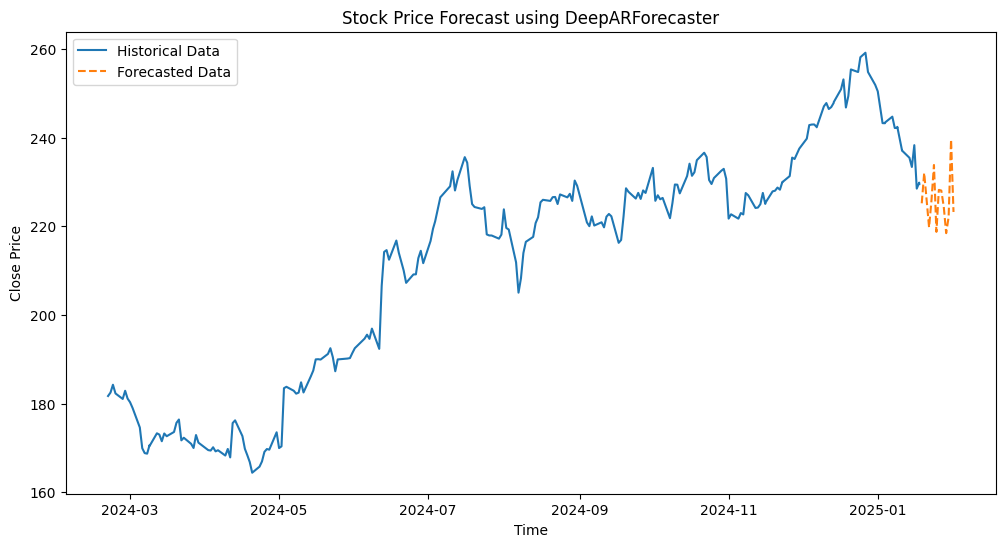

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data["close_price"], label="Historical Data")
plt.plot(forecast_df.index, forecast_df["close_price"], label="Forecasted Data", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Stock Price Forecast using DeepARForecaster")
plt.legend()
plt.show()

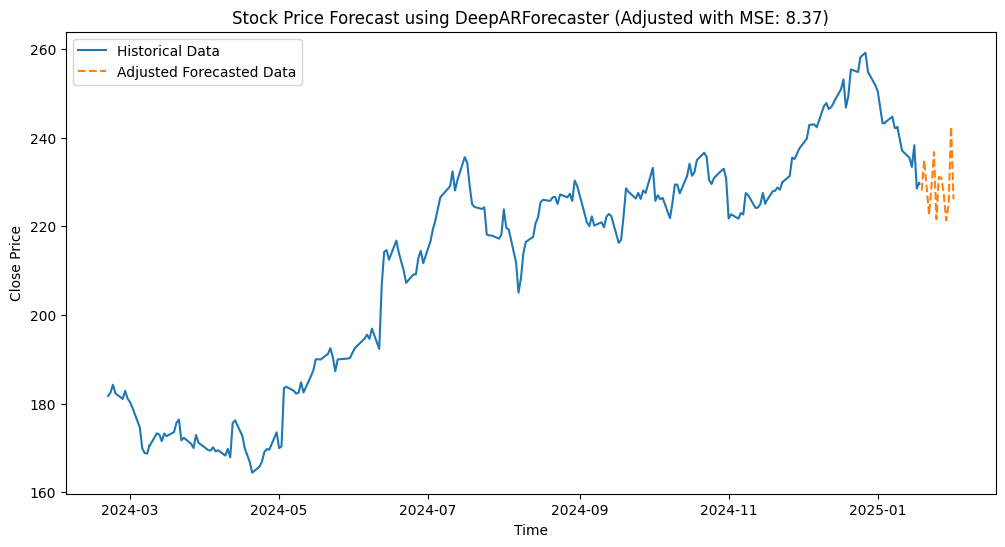

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
last_actual_values = historical_data["close_price"].iloc[-7:]
last_forecasted_values = forecast_df["close_price"].iloc[:7]
if len(last_actual_values) == len(last_forecasted_values):
    from sklearn.metrics import mean_absolute_error
    mse = mean_absolute_error(last_actual_values, last_forecasted_values)
    
    forecast_df["adjusted_close_price"] = forecast_df["close_price"] + np.sqrt(mse)

    plt.figure(figsize=(12, 6))
    plt.plot(historical_data.index, historical_data["close_price"], label="Historical Data")
    plt.plot(forecast_df.index, forecast_df["adjusted_close_price"], label="Adjusted Forecasted Data", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.title(f"Stock Price Forecast using DeepARForecaster (Adjusted with MSE: {mse:.2f})")
    plt.legend()
    plt.show()
else:
    print("The length of the last actual values and forecasted values do not match.")


In [15]:
print(forecast_df)

                     close_price  adjusted_close_price
time                                                  
2025-01-19 00:55:00   225.161250            228.053526
2025-01-20 00:55:00   232.026904            234.919180
2025-01-21 00:55:00   225.882582            228.774859
2025-01-22 00:55:00   219.733415            222.625692
2025-01-23 00:55:00   225.941824            228.834100
2025-01-24 00:55:00   233.804547            236.696824
2025-01-25 00:55:00   218.721628            221.613905
2025-01-26 00:55:00   228.193831            231.086107
2025-01-27 00:55:00   228.034545            230.926822
2025-01-28 00:55:00   224.436516            227.328792
2025-01-29 00:55:00   218.425966            221.318242
2025-01-30 00:55:00   222.059477            224.951754
2025-01-31 00:55:00   239.534681            242.426957
2025-02-01 00:55:00   223.203150            226.095427


In [16]:
mse

8.365263378697644